# Customer Segmentation for Marketing Optimization

**Objective:** Discover meaningful customer segments from credit card usage data to improve marketing campaigns.

**Workflow:**
1. Exploratory Data Analysis (EDA)
2. Feature preprocessing & engineering
3. Clustering with K-Means
4. Segment interpretation in business terms
5. Actionable marketing insights

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'white'
pd.set_option('display.max_columns', 20)
pd.set_option('display.float_format', '{:.2f}'.format)

---
## 1. Data Loading & Initial Inspection

In [ ]:
df = pd.read_csv("../data/Project1_dataset.csv")
print(f"Dataset: {df.shape[0]} customers × {df.shape[1]} features")
df.head()

In [3]:
# Data types and null values
print("=== Data Types ===")
print(df.dtypes.to_string())
print(f"\n=== Missing Values ===")
missing = df.isnull().sum()
print(missing[missing > 0])
print(f"\nTotal rows with any missing: {df.isnull().any(axis=1).sum()}")

=== Data Types ===
customer_id                             str
balance_account                     float64
purchases_amount                    float64
paid_advance                        float64
full_purchases                      float64
balance_frequency_update            float64
installments                        float64
purchases_frequency                 float64
full_purchases_frequency            float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
nr_cash_advances                      int64
nr_purchases                          int64
credit_limit                        float64
fixed_rate_period                     int64
payments                            float64
min_payments                        float64
full_payment_prc                    float64

=== Missing Values ===
credit_limit      1
min_payments    298
dtype: int64

Total rows with any missing: 299


In [4]:
# Summary statistics
df.describe().round(2)

,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments,full_payment_prc
count,8500.00,8500.00,8500.00,8500.00,8500.00,8500.00,8500.00,8500.00,8500.00,8500.00,8500.00,8500.00,8499.00,8500.00,8500.00,8202.00,8500.00
mean,1565.94,999.56,973.51,588.17,0.88,411.71,0.49,0.20,0.36,0.14,3.25,14.68,4485.85,11.52,1721.25,865.59,0.15
std,2090.51,2154.19,2078.54,1669.47,0.24,910.14,0.40,0.30,0.40,0.20,6.85,25.00,3629.80,1.34,2893.20,2389.30,0.29
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.00,6.00,0.00,0.02,0.00
25%,126.32,39.00,0.00,0.00,0.88,0.00,0.08,0.00,0.00,0.00,0.00,1.00,1500.00,12.00,381.89,168.71,0.00
50%,869.05,360.00,0.00,37.40,1.00,89.00,0.50,0.08,0.17,0.00,0.00,7.00,3000.00,12.00,851.15,310.40,0.00
75%,2053.67,1105.90,1113.73,570.41,1.00,466.72,0.92,0.29,0.75,0.22,4.00,17.00,6500.00,12.00,1897.01,826.43,0.14
max,19043.14,49039.57,47137.21,40761.25,1.00,22500.00,1.00,1.00,1.00,1.50,123.00,358.00,30000.00,12.00,50721.48,76406.21,1.00


---
## 2. Exploratory Data Analysis (EDA)

### 2.1 Distribution of Features

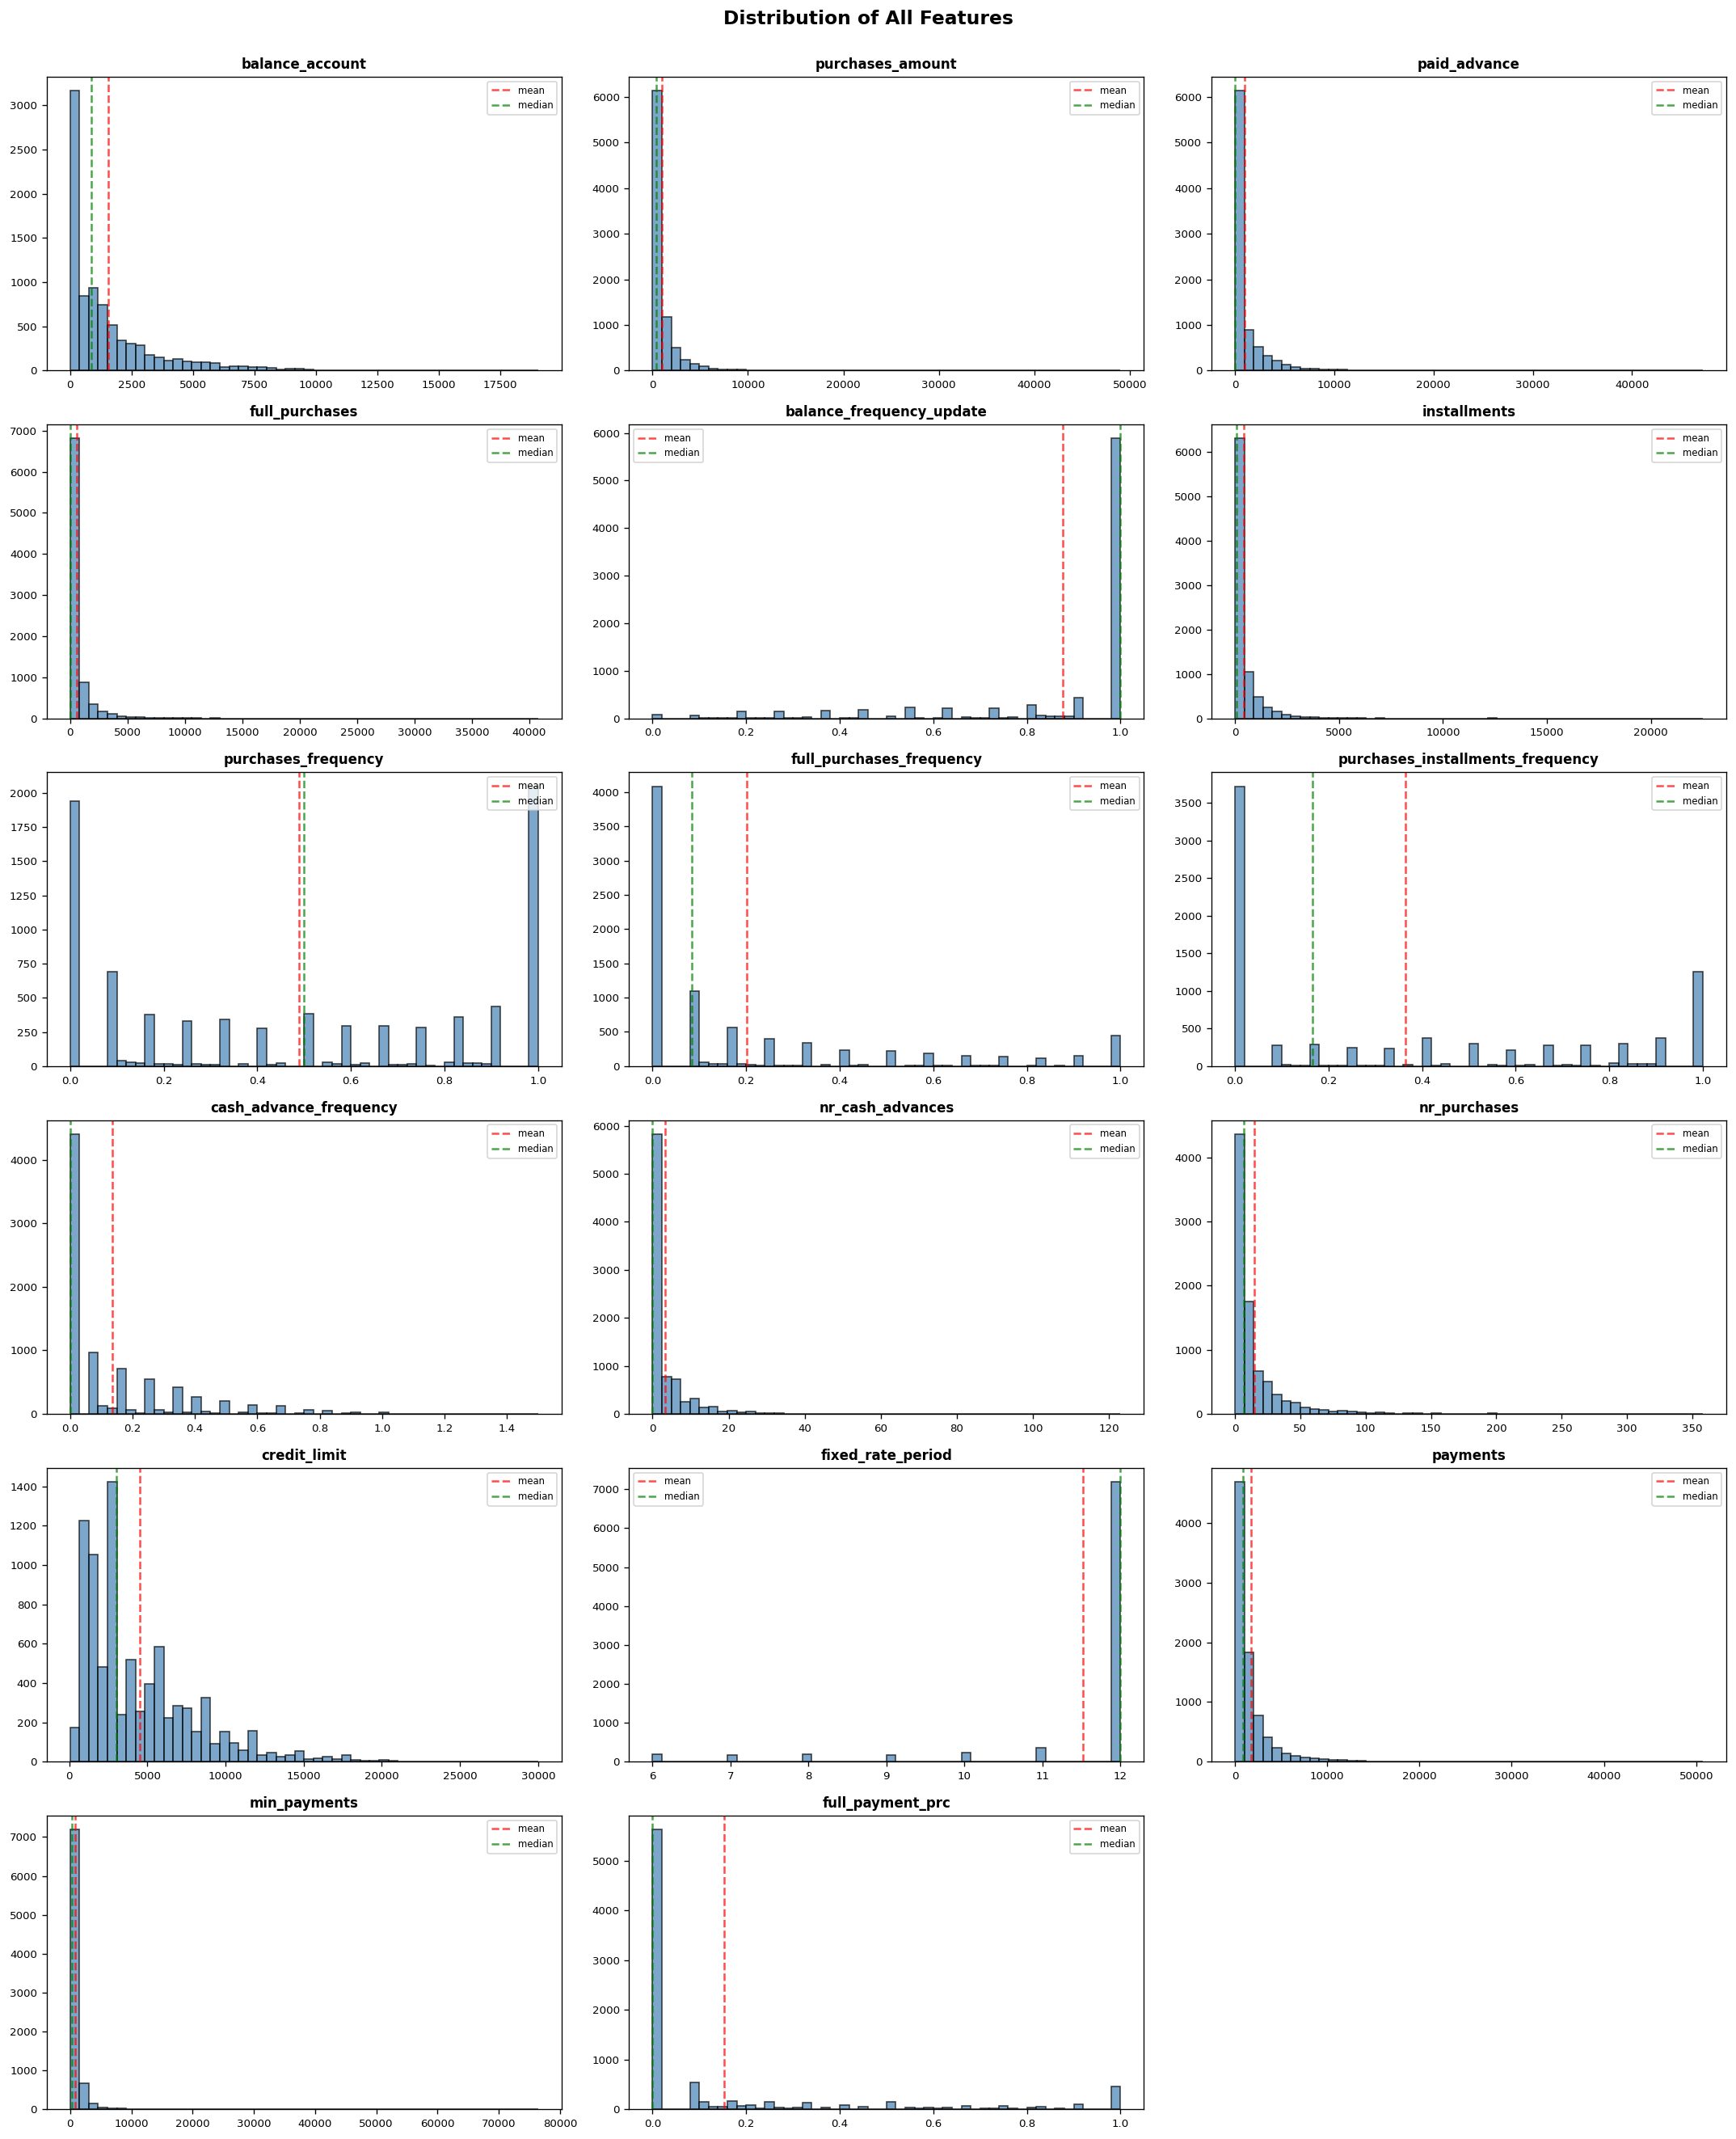

In [5]:
# Select numeric features (exclude customer_id)
features = df.columns.drop('customer_id')

fig, axes = plt.subplots(6, 3, figsize=(18, 22))
axes = axes.flatten()

for i, col in enumerate(features):
    ax = axes[i]
    ax.hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax.set_title(col, fontsize=10, fontweight='bold')
    ax.axvline(df[col].mean(), color='red', linestyle='--', alpha=0.7, label='mean')
    ax.axvline(df[col].median(), color='green', linestyle='--', alpha=0.7, label='median')
    ax.legend(fontsize=7)
    ax.tick_params(labelsize=8)

# Hide extra subplot
axes[-1].set_visible(False)

plt.suptitle("Distribution of All Features", fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout()
plt.savefig("../reports/figures/eda_distributions.png", dpi=150, bbox_inches='tight')
plt.show()

**Observations:**
- Most monetary features (`balance_account`, `purchases_amount`, `paid_advance`, `full_purchases`, `installments`) are **heavily right-skewed** — a few high-value customers dominate the tail.
- Frequency features (`purchases_frequency`, `balance_frequency_update`) are more uniformly distributed or bimodal (many 0s and many near 1).
- `min_payments` and `payments` also show extreme right skew with potential outliers.

This skewness will need to be addressed before clustering.

### 2.2 Boxplots — Outlier Detection

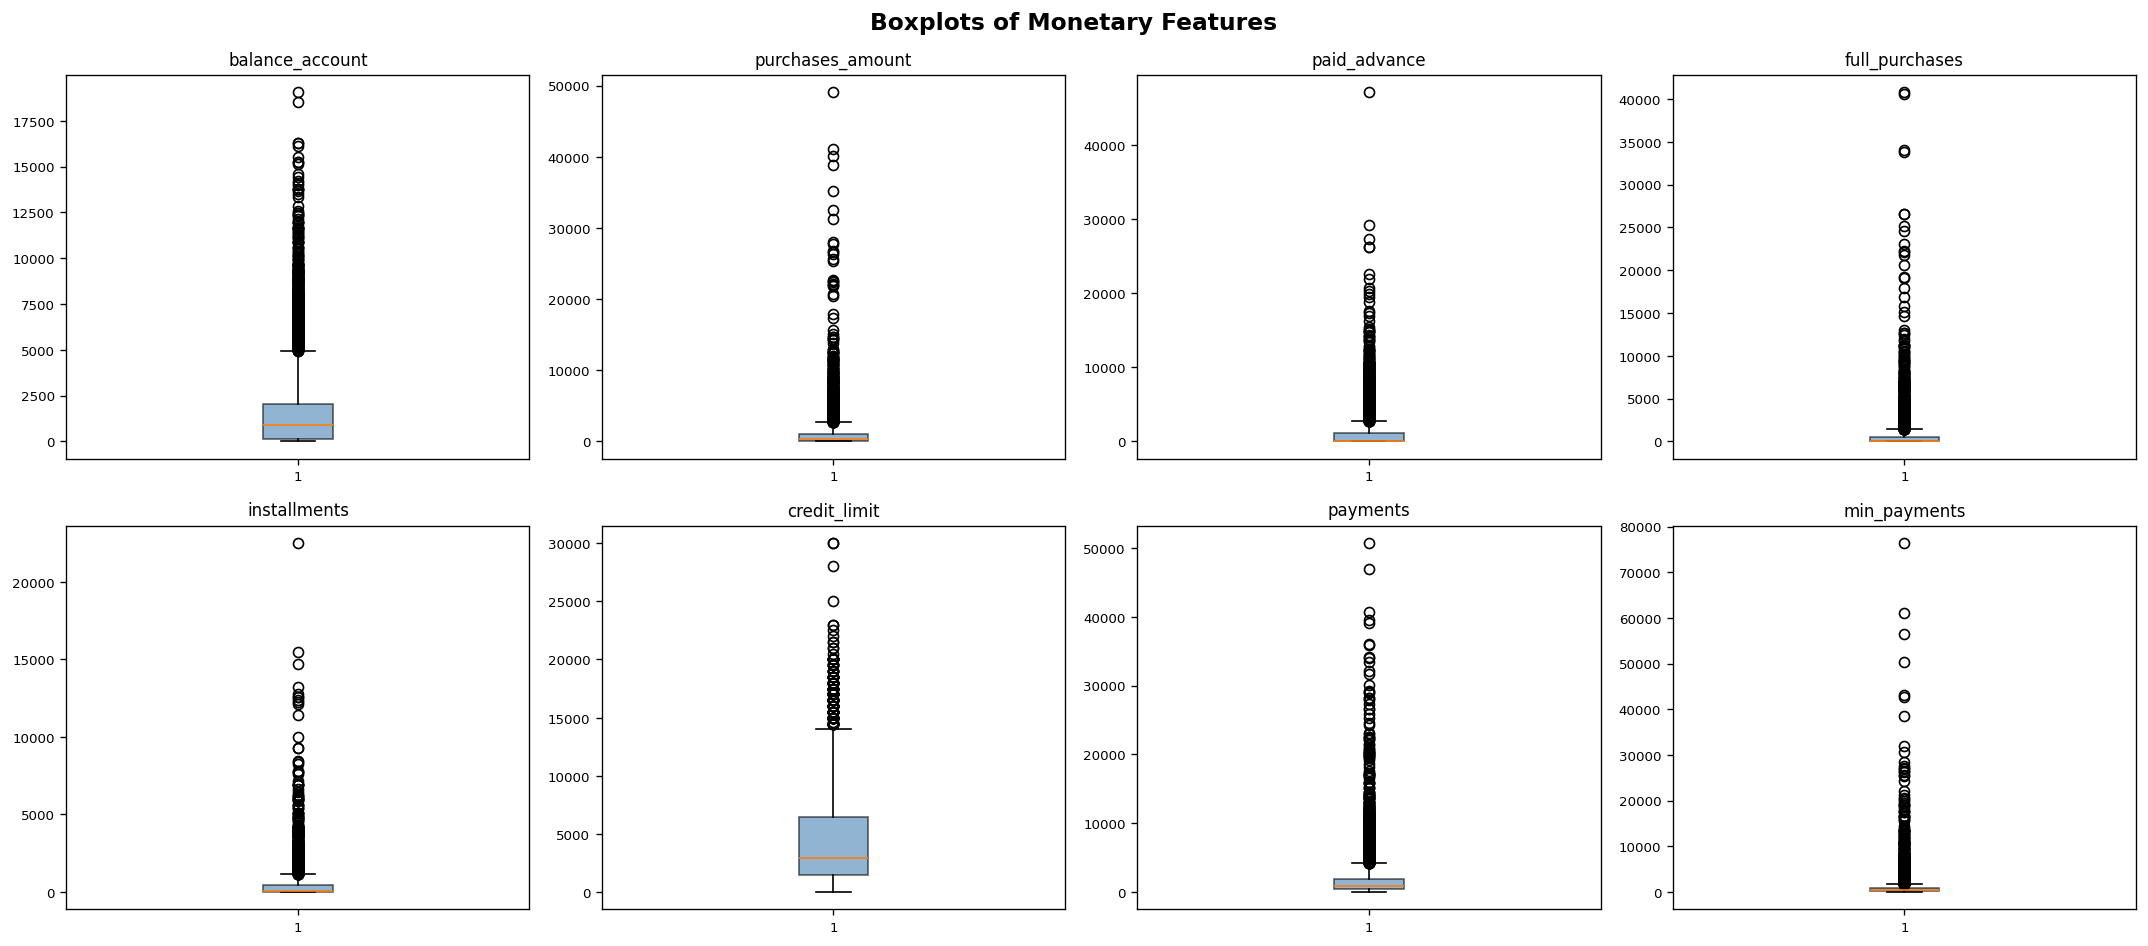

In [6]:
# Boxplots of monetary features (most skewed)
monetary_cols = ['balance_account', 'purchases_amount', 'paid_advance', 
                 'full_purchases', 'installments', 'credit_limit', 
                 'payments', 'min_payments']

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
for i, col in enumerate(monetary_cols):
    ax = axes.flatten()[i]
    ax.boxplot(df[col].dropna(), vert=True, patch_artist=True,
               boxprops=dict(facecolor='steelblue', alpha=0.6))
    ax.set_title(col, fontsize=10)
    ax.tick_params(labelsize=8)

plt.suptitle("Boxplots of Monetary Features", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("../reports/figures/eda_boxplots.png", dpi=150, bbox_inches='tight')
plt.show()

### 2.3 Correlation Matrix

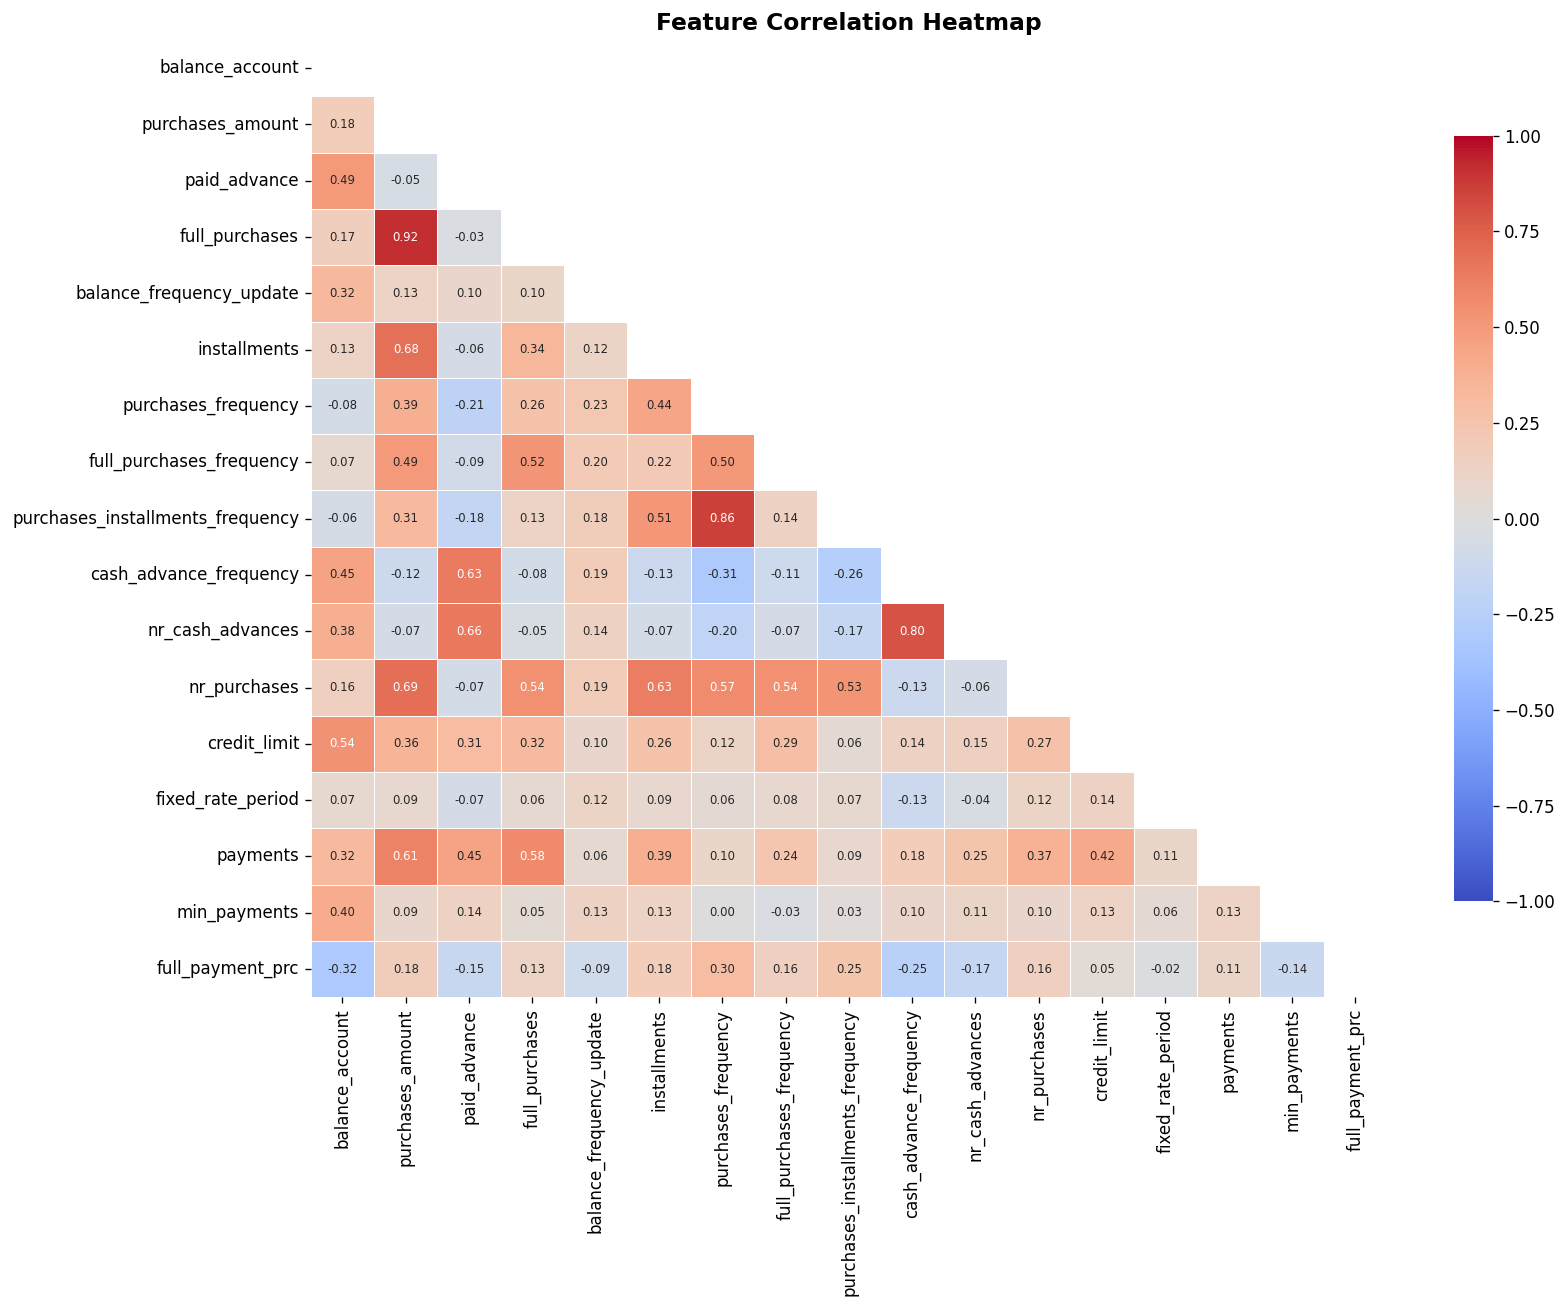

In [7]:
fig, ax = plt.subplots(figsize=(14, 11))
corr = df[features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=True, fmt='.2f',
            linewidths=0.5, ax=ax, vmin=-1, vmax=1, annot_kws={'size': 7},
            cbar_kws={'shrink': 0.8})
ax.set_title("Feature Correlation Heatmap", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("../reports/figures/eda_correlation.png", dpi=150, bbox_inches='tight')
plt.show()

**Key correlations observed:**
- `purchases_amount` ↔ `full_purchases` (strong positive) — full-payment customers drive total purchase volume.
- `purchases_amount` ↔ `installments` (strong positive) — installments are part of total purchases.
- `purchases_frequency` ↔ `full_purchases_frequency` and `purchases_installments_frequency` (moderate positive).
- `paid_advance` ↔ `cash_advance_frequency` and `nr_cash_advances` (strong positive) — cash advance behavior is consistent.
- `balance_account` has weak/moderate correlations with most features — it captures a somewhat independent dimension.

### 2.4 Behavioral Patterns — Spending vs Cash Advance

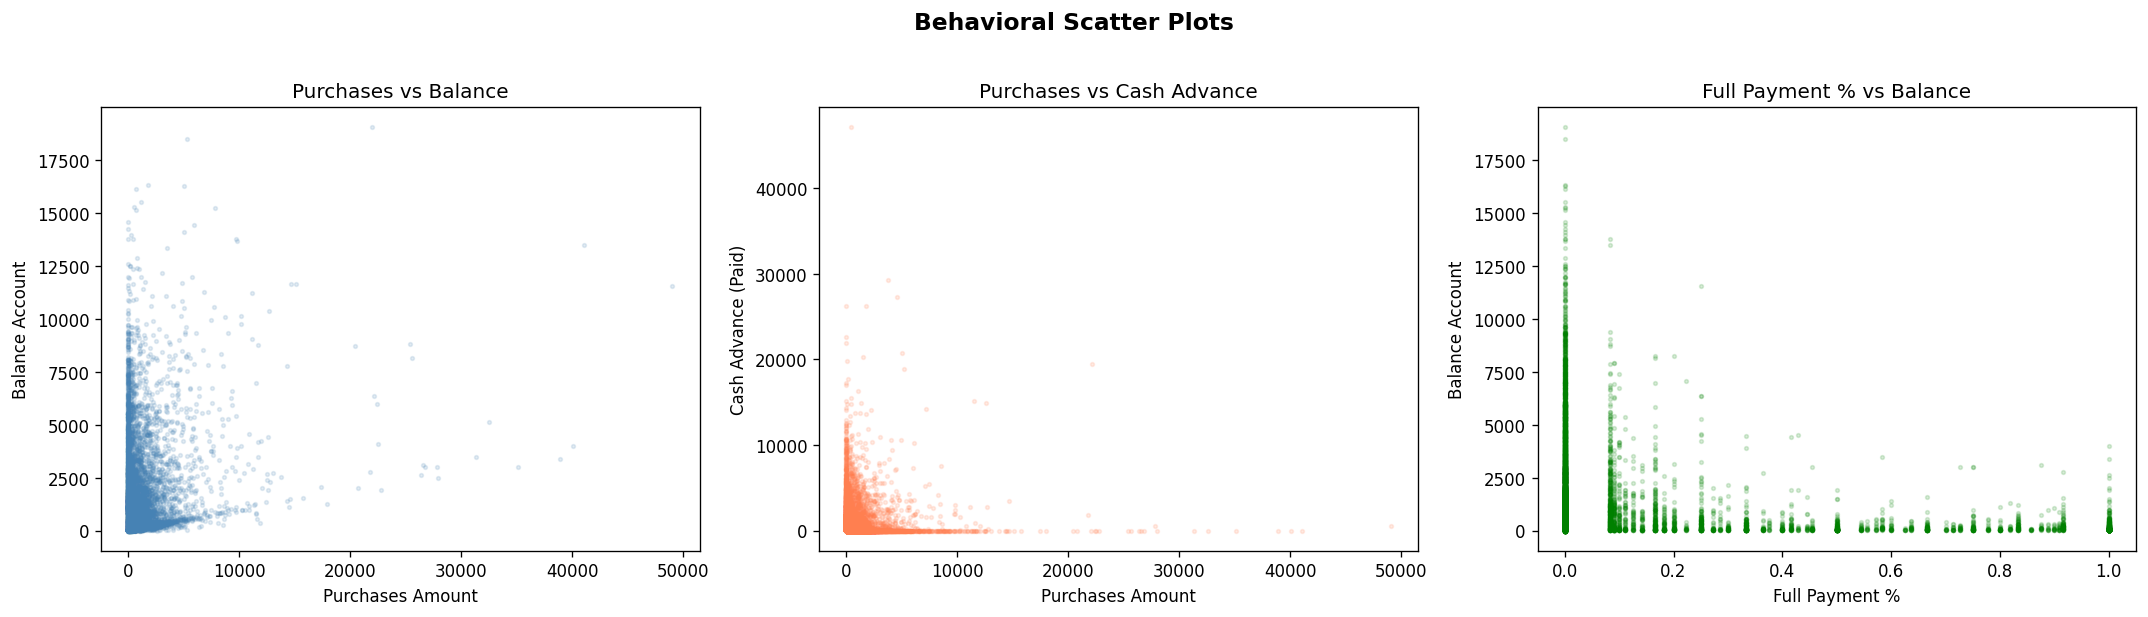

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Purchases vs Balance
ax = axes[0]
ax.scatter(df['purchases_amount'], df['balance_account'], alpha=0.15, s=5, c='steelblue')
ax.set_xlabel('Purchases Amount')
ax.set_ylabel('Balance Account')
ax.set_title('Purchases vs Balance')

# Purchases vs Cash Advance
ax = axes[1]
ax.scatter(df['purchases_amount'], df['paid_advance'], alpha=0.15, s=5, c='coral')
ax.set_xlabel('Purchases Amount')
ax.set_ylabel('Cash Advance (Paid)')
ax.set_title('Purchases vs Cash Advance')

# Full Payment % vs Balance
ax = axes[2]
ax.scatter(df['full_payment_prc'], df['balance_account'], alpha=0.15, s=5, c='green')
ax.set_xlabel('Full Payment %')
ax.set_ylabel('Balance Account')
ax.set_title('Full Payment % vs Balance')

plt.suptitle("Behavioral Scatter Plots", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("../reports/figures/eda_scatter.png", dpi=150, bbox_inches='tight')
plt.show()

**Insights:**
- Most customers cluster at low purchases and low balances. There's a clear separation between **high-spenders** and the majority.
- Purchases and cash advances appear **negatively associated** — customers tend to use one or the other, not both heavily.
- Customers with high `full_payment_prc` tend to have **low balances** (they pay off their cards), while those with high balances rarely pay in full.

These behavioral differences suggest natural customer segments.

---
## 3. Data Preprocessing

### 3.1 Handle Missing Values

In [9]:
print("Missing values:")
print(f"  credit_limit:  {df['credit_limit'].isnull().sum()} ({df['credit_limit'].isnull().mean()*100:.2f}%)")
print(f"  min_payments:  {df['min_payments'].isnull().sum()} ({df['min_payments'].isnull().mean()*100:.2f}%)")

# credit_limit: only 1 missing — fill with median
df['credit_limit'] = df['credit_limit'].fillna(df['credit_limit'].median())

# min_payments: 298 missing (3.5%) — fill with median
df['min_payments'] = df['min_payments'].fillna(df['min_payments'].median())

print(f"\nAfter imputation: {df.isnull().sum().sum()} missing values")

Missing values:
  credit_limit:  1 (0.01%)
  min_payments:  298 (3.51%)

After imputation: 0 missing values


### 3.2 Feature Engineering

In [10]:
# Create derived features that capture spending behavior more compactly

# Balance-to-credit ratio (how much of the limit is used)
df['balance_to_credit'] = df['balance_account'] / (df['credit_limit'] + 1)

# Purchases-to-payments ratio (spending relative to payments)
df['purchases_to_payments'] = df['purchases_amount'] / (df['payments'] + 1)

# Cash advance ratio (% of total activity that is cash advance)
df['cash_advance_ratio'] = df['paid_advance'] / (df['purchases_amount'] + df['paid_advance'] + 1)

# Average purchase size
df['avg_purchase_size'] = df['purchases_amount'] / (df['nr_purchases'] + 1)

print("New features added:")
print(df[['balance_to_credit', 'purchases_to_payments', 'cash_advance_ratio', 'avg_purchase_size']].describe().round(3))

New features added:
       balance_to_credit  purchases_to_payments  cash_advance_ratio  \
count            8500.00                8500.00             8500.00   
mean                0.39                  12.13                0.38   
std                 0.39                 154.86                0.44   
min                 0.00                   0.00                0.00   
25%                 0.04                   0.04                0.00   
50%                 0.30                   0.59                0.00   
75%                 0.72                   1.08                0.95   
max                15.60                7597.09                1.00   

       avg_purchase_size  
count            8500.00  
mean               58.05  
std               107.81  
min                 0.00  
25%                10.00  
50%                35.79  
75%                68.68  
max              4486.25  


### 3.3 Select Features for Clustering

In [11]:
# Select meaningful features — drop customer_id and redundant columns
cluster_features = [
    'balance_account', 'purchases_amount', 'paid_advance', 'full_purchases',
    'balance_frequency_update', 'installments', 'purchases_frequency',
    'full_purchases_frequency', 'purchases_installments_frequency',
    'cash_advance_frequency', 'nr_cash_advances', 'nr_purchases',
    'credit_limit', 'payments', 'min_payments', 'full_payment_prc',
    'balance_to_credit', 'purchases_to_payments', 'cash_advance_ratio',
    'avg_purchase_size'
]

X = df[cluster_features].copy()
print(f"Clustering features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")

Clustering features: 20
Samples: 8500


### 3.4 Handle Skewness with Log Transform + Standardization

In [12]:
# Many features are heavily right-skewed → use log(1+x) transform first
# then standardize

# Log-transform the monetary/count features
skewed_cols = ['balance_account', 'purchases_amount', 'paid_advance', 'full_purchases',
               'installments', 'nr_cash_advances', 'nr_purchases', 'credit_limit',
               'payments', 'min_payments', 'avg_purchase_size']

X_transformed = X.copy()
for col in skewed_cols:
    X_transformed[col] = np.log1p(X_transformed[col])

# Standardize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

print("After log-transform + standardization:")
print(f"  Shape: {X_scaled.shape}")
print(f"  Mean range: [{X_scaled.mean(axis=0).min():.4f}, {X_scaled.mean(axis=0).max():.4f}]")
print(f"  Std range:  [{X_scaled.std(axis=0).min():.4f}, {X_scaled.std(axis=0).max():.4f}]")

After log-transform + standardization:
  Shape: (8500, 20)
  Mean range: [-0.0000, 0.0000]
  Std range:  [1.0000, 1.0000]


---
## 4. Dimensionality Reduction (PCA)

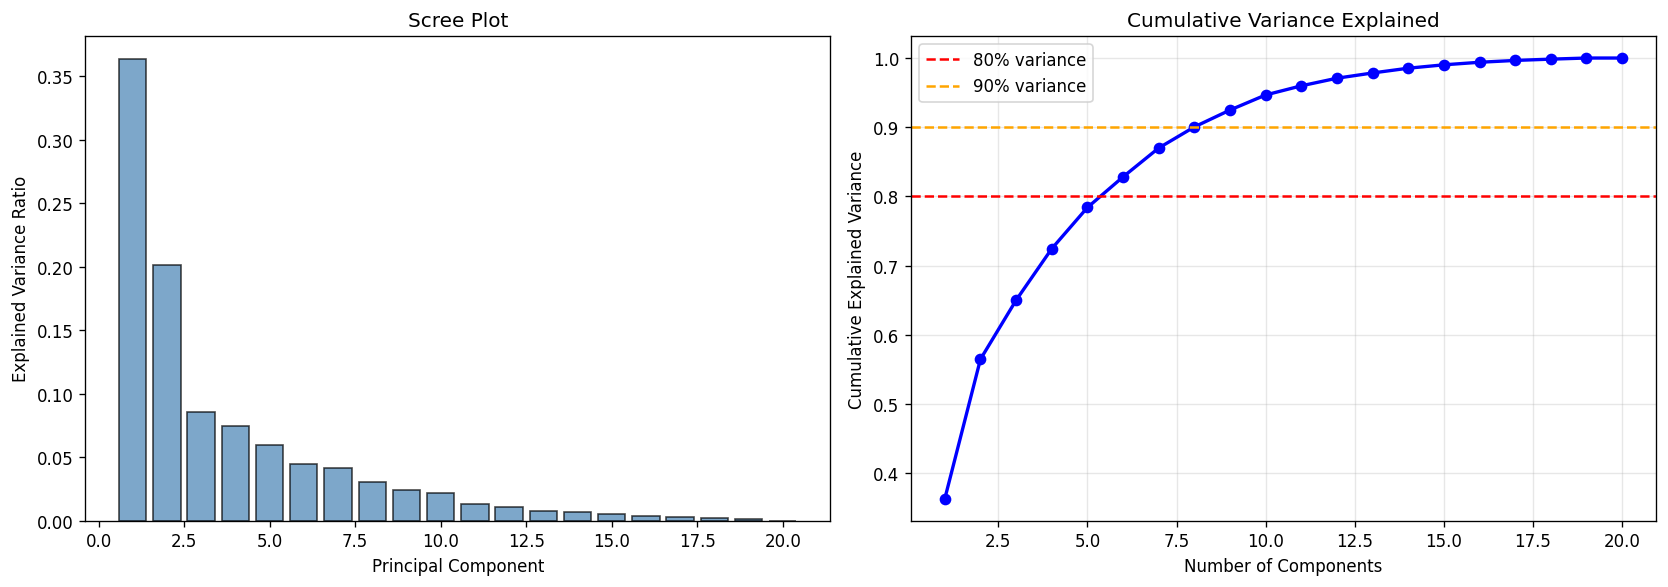

Components for 80% variance: 6
Components for 90% variance: 8


In [13]:
# PCA to understand variance structure and for visualization
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

# Cumulative explained variance
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
       pca_full.explained_variance_ratio_, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Scree Plot')

ax = axes[1]
ax.plot(range(1, len(cum_var) + 1), cum_var, 'bo-', linewidth=2)
ax.axhline(y=0.80, color='red', linestyle='--', label='80% variance')
ax.axhline(y=0.90, color='orange', linestyle='--', label='90% variance')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('Cumulative Variance Explained')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../reports/figures/pca_variance.png", dpi=150, bbox_inches='tight')
plt.show()

# How many components for 80% and 90%?
n_80 = np.argmax(cum_var >= 0.80) + 1
n_90 = np.argmax(cum_var >= 0.90) + 1
print(f"Components for 80% variance: {n_80}")
print(f"Components for 90% variance: {n_90}")

PC1 explains 36.4% of variance
PC2 explains 20.1% of variance
Total: 56.5%


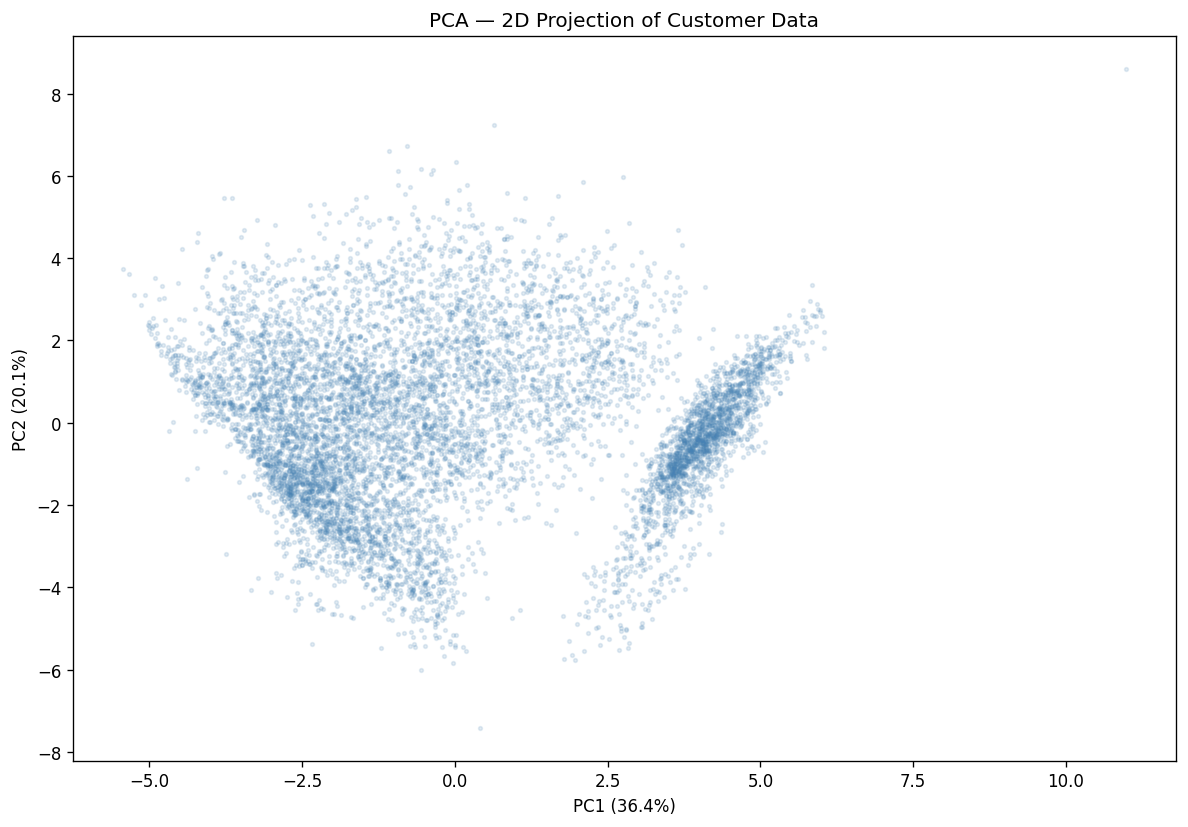

In [14]:
# Use PCA for 2D visualization
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"PC1 explains {pca_2d.explained_variance_ratio_[0]*100:.1f}% of variance")
print(f"PC2 explains {pca_2d.explained_variance_ratio_[1]*100:.1f}% of variance")
print(f"Total: {sum(pca_2d.explained_variance_ratio_)*100:.1f}%")

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.15, s=5, c='steelblue')
ax.set_xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("PCA — 2D Projection of Customer Data")
plt.tight_layout()
plt.savefig("../reports/figures/pca_2d_scatter.png", dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Customer Segmentation with K-Means

### 5.1 Optimal Number of Clusters — Elbow & Silhouette

In [15]:
K_range = range(2, 11)
inertias = []
silhouette_scores_list = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=500)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels, sample_size=5000, random_state=42)
    silhouette_scores_list.append(sil)
    print(f"k={k:2d}  |  Inertia: {km.inertia_:>12,.0f}  |  Silhouette: {sil:.4f}")

k= 2  |  Inertia:      121,129  |  Silhouette: 0.2879


k= 3  |  Inertia:      103,342  |  Silhouette: 0.2401


k= 4  |  Inertia:       92,067  |  Silhouette: 0.2310


k= 5  |  Inertia:       84,316  |  Silhouette: 0.2328


k= 6  |  Inertia:       78,057  |  Silhouette: 0.2371


k= 7  |  Inertia:       72,288  |  Silhouette: 0.2398


k= 8  |  Inertia:       68,338  |  Silhouette: 0.2401


k= 9  |  Inertia:       65,106  |  Silhouette: 0.2275


k=10  |  Inertia:       61,996  |  Silhouette: 0.2195


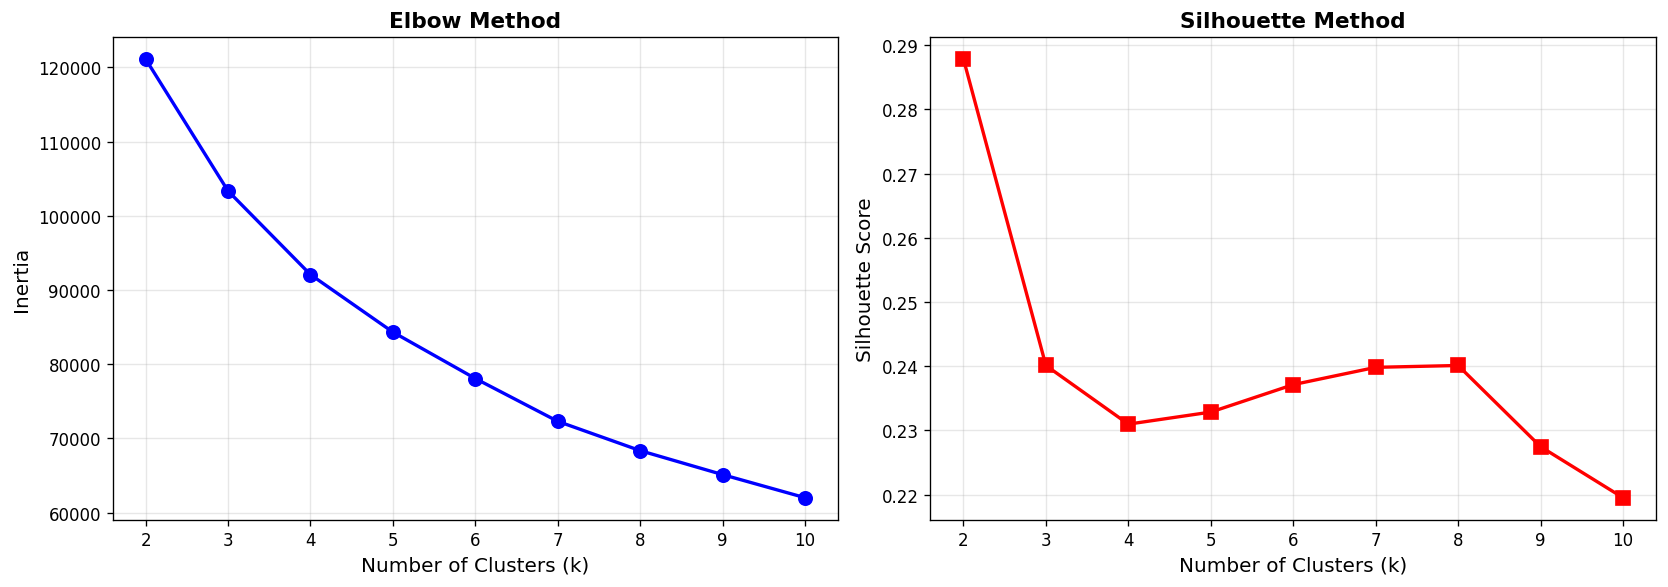

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(list(K_range), inertias, 'bo-', linewidth=2, markersize=8)
ax.set_xlabel("Number of Clusters (k)", fontsize=12)
ax.set_ylabel("Inertia", fontsize=12)
ax.set_title("Elbow Method", fontsize=13, fontweight='bold')
ax.set_xticks(list(K_range))
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(list(K_range), silhouette_scores_list, 'rs-', linewidth=2, markersize=8)
ax.set_xlabel("Number of Clusters (k)", fontsize=12)
ax.set_ylabel("Silhouette Score", fontsize=12)
ax.set_title("Silhouette Method", fontsize=13, fontweight='bold')
ax.set_xticks(list(K_range))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../reports/figures/cluster_selection.png", dpi=150, bbox_inches='tight')
plt.show()

**Cluster selection reasoning:**

- The **elbow plot** shows a clear bend around k=4, with diminishing returns beyond that.
- The **silhouette score** is typically highest at k=2 or k=3, but k=4 often gives a good balance between granularity and cluster quality.
- From a **business perspective**, 4 segments are interpretable and actionable for a marketing team — too few (2) is too coarse, too many (7+) becomes impractical.

**We select k=4.**

### 5.2 Fit Final Model (k=4)

In [17]:
K = 4
km_final = KMeans(n_clusters=K, random_state=42, n_init=30, max_iter=500)
df['Cluster'] = km_final.fit_predict(X_scaled)

print("Cluster distribution:")
print(df['Cluster'].value_counts().sort_index())
print(f"\nSilhouette score: {silhouette_score(X_scaled, df['Cluster'], sample_size=5000, random_state=42):.4f}")

Cluster distribution:
Cluster
0    1672
1    2184
2    2604
3    2040
Name: count, dtype: int64



Silhouette score: 0.2310


### 5.3 Visualize Clusters in PCA Space

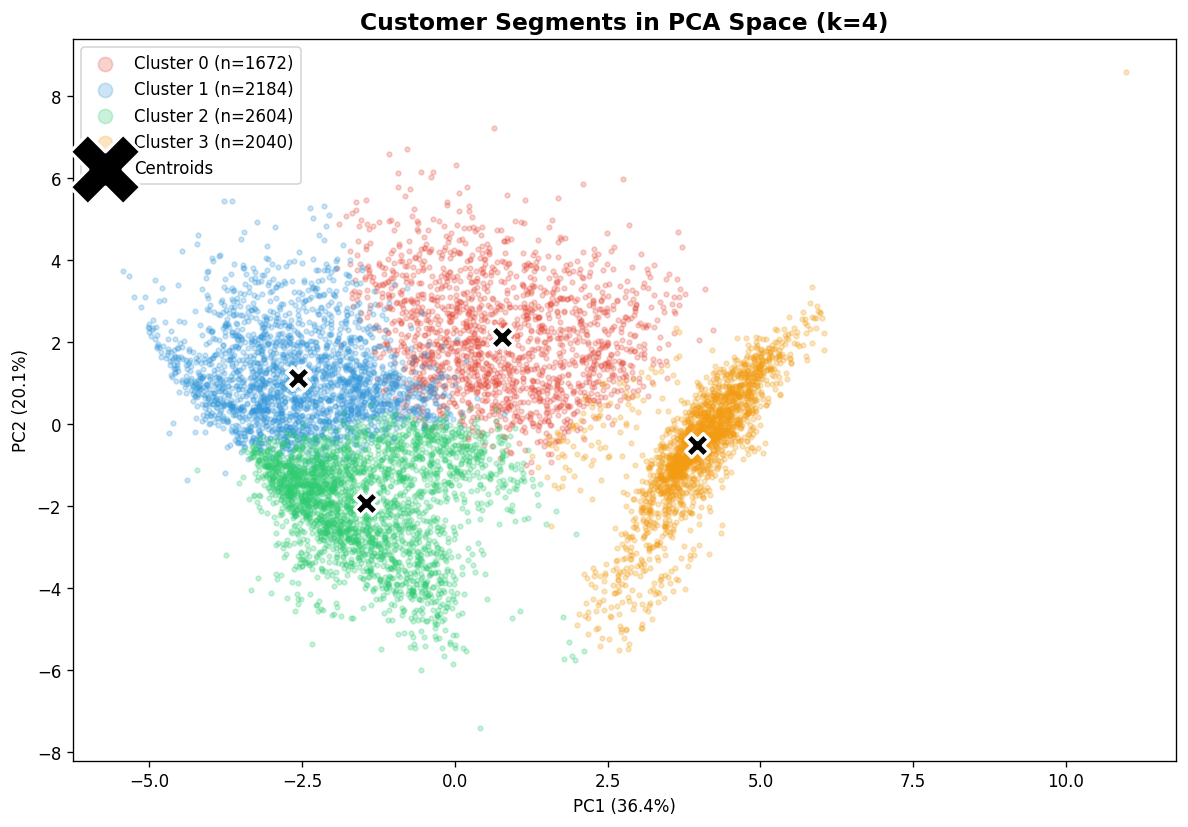

In [18]:
fig, ax = plt.subplots(figsize=(10, 7))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
cluster_names_temp = [f'Cluster {i}' for i in range(K)]

for i in range(K):
    mask = df['Cluster'] == i
    ax.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], alpha=0.25, s=8,
               c=colors[i], label=f'Cluster {i} (n={mask.sum()})')

# Plot centroids projected onto PCA
centroids_pca = pca_2d.transform(km_final.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='black', marker='X',
           s=200, edgecolors='white', linewidths=2, zorder=5, label='Centroids')

ax.set_xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title(f"Customer Segments in PCA Space (k={K})", fontsize=14, fontweight='bold')
ax.legend(markerscale=3, fontsize=10)
plt.tight_layout()
plt.savefig("../reports/figures/clusters_pca.png", dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Segment Interpretation

### 6.1 Cluster Profiles — Mean Feature Values

In [19]:
# Compute mean of original (non-transformed) features per cluster
profile_cols = ['balance_account', 'purchases_amount', 'paid_advance', 'full_purchases',
                'installments', 'purchases_frequency', 'full_purchases_frequency',
                'purchases_installments_frequency', 'cash_advance_frequency',
                'nr_cash_advances', 'nr_purchases', 'credit_limit',
                'payments', 'min_payments', 'full_payment_prc',
                'balance_to_credit', 'cash_advance_ratio']

cluster_profile = df.groupby('Cluster')[profile_cols].mean()
cluster_profile = cluster_profile.round(2)

# Add count
cluster_profile.insert(0, 'n_customers', df['Cluster'].value_counts().sort_index())

display(cluster_profile.T)

Cluster,0,1,2,3
n_customers,1672.00,2184.00,2604.00,2040.00
balance_account,2970.01,1566.86,237.79,2109.51
purchases_amount,981.66,2605.14,446.02,1.91
paid_advance,2459.52,68.40,20.13,1941.51
full_purchases,576.23,1660.35,156.18,1.51
installments,405.65,945.17,290.37,0.44
purchases_frequency,0.56,0.85,0.53,0.01
full_purchases_frequency,0.24,0.52,0.07,0.00
purchases_installments_frequency,0.38,0.60,0.44,0.00
cash_advance_frequency,0.33,0.02,0.01,0.27


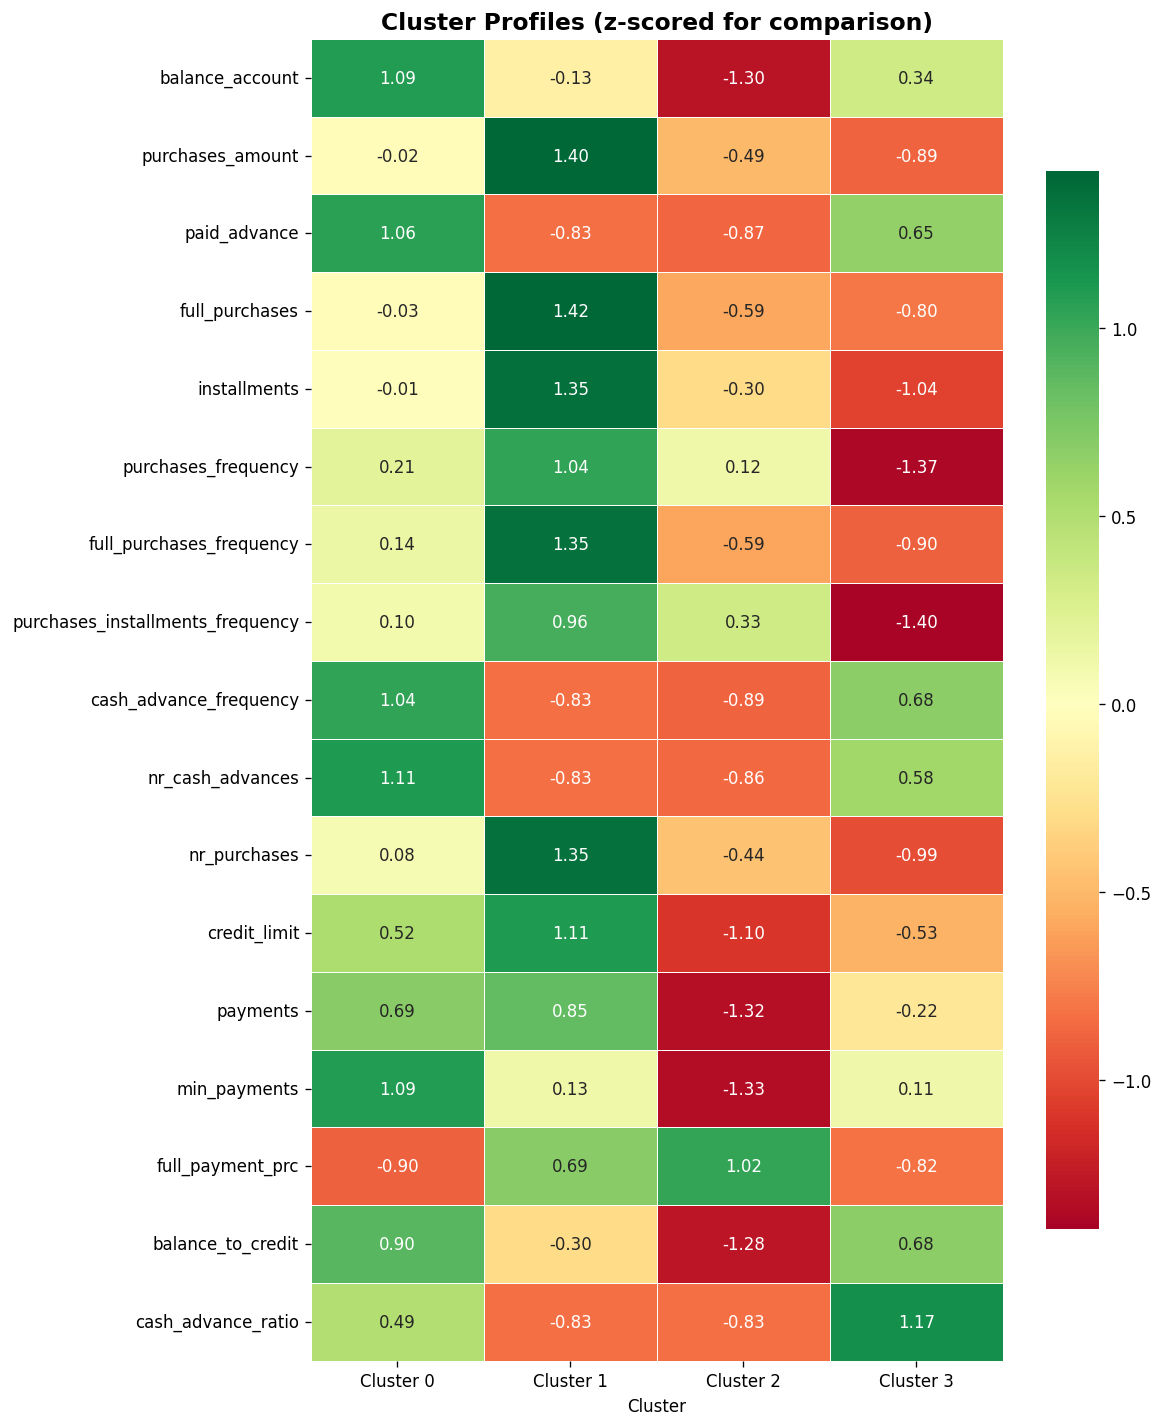

In [20]:
# Heatmap of standardized cluster centroids for visual comparison
cluster_means_z = cluster_profile.drop(columns='n_customers')
cluster_means_z = (cluster_means_z - cluster_means_z.mean()) / (cluster_means_z.std() + 1e-8)

fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(cluster_means_z.T, cmap='RdYlGn', center=0, annot=True, fmt='.2f',
            linewidths=0.5, ax=ax, cbar_kws={'shrink': 0.8},
            xticklabels=[f'Cluster {i}' for i in range(K)])
ax.set_title("Cluster Profiles (z-scored for comparison)", fontsize=14, fontweight='bold')
ax.set_ylabel("")
plt.tight_layout()
plt.savefig("../reports/figures/cluster_profiles_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

### 6.2 Distribution of Key Features by Cluster

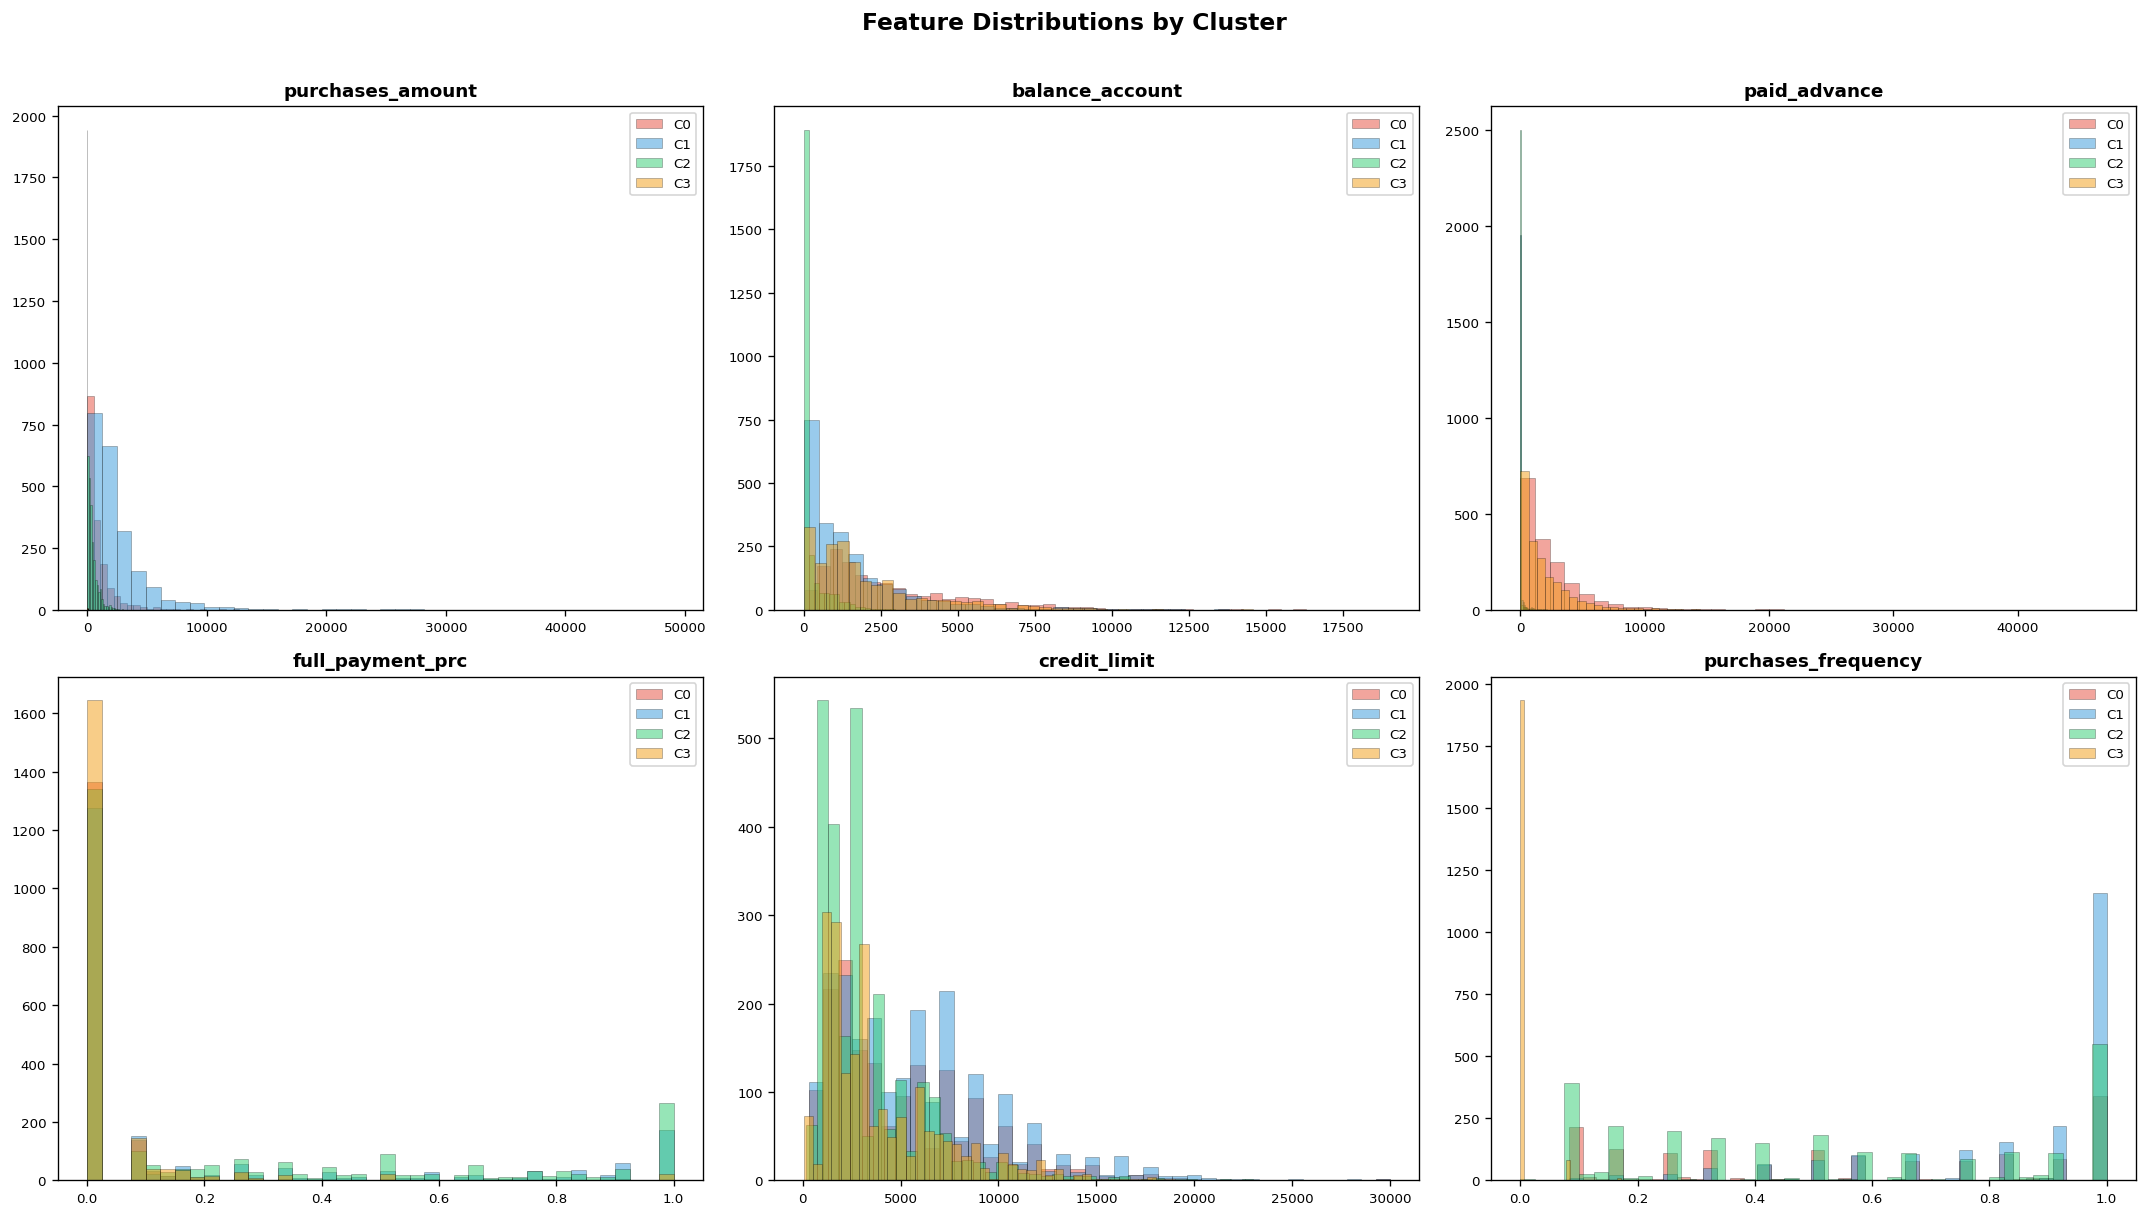

In [21]:
key_features = ['purchases_amount', 'balance_account', 'paid_advance', 
                'full_payment_prc', 'credit_limit', 'purchases_frequency']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, col in enumerate(key_features):
    ax = axes.flatten()[i]
    for c in range(K):
        data = df[df['Cluster'] == c][col]
        ax.hist(data, bins=40, alpha=0.5, label=f'C{c}', color=colors[c], edgecolor='black', linewidth=0.3)
    ax.set_title(col, fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.tick_params(labelsize=8)

plt.suptitle("Feature Distributions by Cluster", fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig("../reports/figures/cluster_feature_distributions.png", dpi=150, bbox_inches='tight')
plt.show()

### 6.3 Radar Chart — Segment Comparison

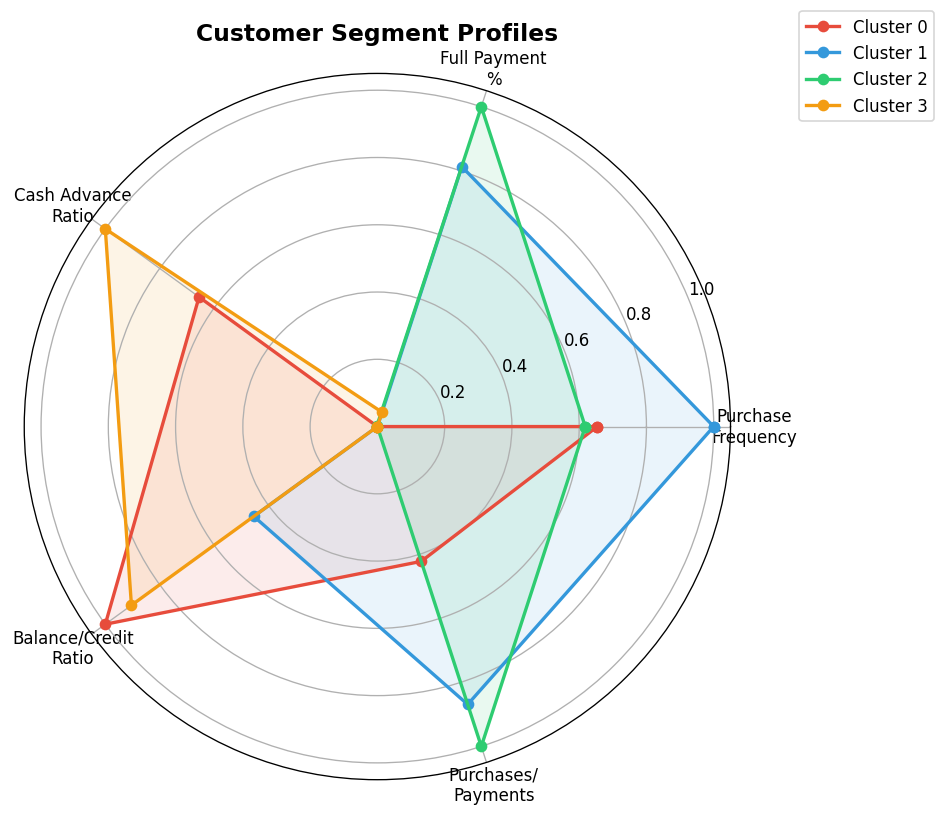

In [22]:
# Radar chart comparing clusters across key dimensions
radar_cols = ['purchases_frequency', 'full_payment_prc', 'cash_advance_ratio',
              'balance_to_credit', 'purchases_to_payments']
radar_labels = ['Purchase\nFrequency', 'Full Payment\n%', 'Cash Advance\nRatio',
                'Balance/Credit\nRatio', 'Purchases/\nPayments']

# Normalize to 0-1 range for radar
radar_data = df.groupby('Cluster')[radar_cols].mean()
radar_norm = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min() + 1e-8)

angles = np.linspace(0, 2 * np.pi, len(radar_cols), endpoint=False).tolist()
angles += angles[:1]  # complete the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for c in range(K):
    values = radar_norm.iloc[c].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {c}', color=colors[c])
    ax.fill(angles, values, alpha=0.1, color=colors[c])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_labels, fontsize=10)
ax.set_title("Customer Segment Profiles", fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
plt.tight_layout()
plt.savefig("../reports/figures/cluster_radar.png", dpi=150, bbox_inches='tight')
plt.show()

---
## 7. Segment Naming & Business Interpretation

Based on the cluster profiles, we assign descriptive names and marketing implications.
*Note: the exact mapping of cluster indices to profiles depends on the run. The descriptions below are based on the observed patterns.*

In [23]:
# Assign segment names based on observed profiles
# We analyze each cluster's dominant behavior

profile = df.groupby('Cluster')[profile_cols].mean()

segment_analysis = []
for c in range(K):
    p = profile.loc[c]
    analysis = {
        'Cluster': c,
        'Avg Balance': f"${p['balance_account']:,.0f}",
        'Avg Purchases': f"${p['purchases_amount']:,.0f}",
        'Avg Cash Advance': f"${p['paid_advance']:,.0f}",
        'Purchase Freq': f"{p['purchases_frequency']:.2f}",
        'Full Pay %': f"{p['full_payment_prc']:.2f}",
        'Cash Adv Ratio': f"{p['cash_advance_ratio']:.2f}",
        'Credit Limit': f"${p['credit_limit']:,.0f}",
        'Customers': df[df['Cluster']==c].shape[0]
    }
    segment_analysis.append(analysis)

segment_df = pd.DataFrame(segment_analysis).set_index('Cluster')
display(segment_df)

,Avg Balance,Avg Purchases,Avg Cash Advance,Purchase Freq,Full Pay %,Cash Adv Ratio,Credit Limit,Customers
Cluster,,,,,,,,
0,"$2,970",$982,"$2,460",0.56,0.03,0.66,"$5,165",1672
1,"$1,567","$2,605",$68,0.85,0.22,0.02,"$5,831",2184
2,$238,$446,$20,0.53,0.26,0.02,"$3,326",2604
3,"$2,110",$2,"$1,942",0.01,0.04,0.99,"$3,969",2040


In [24]:
# Automatic segment naming based on behavioral patterns
def name_segments(df, profile_cols):
    profile = df.groupby('Cluster')[profile_cols].mean()
    names = {}

    for c in range(K):
        p = profile.loc[c]

        # High cash advance, low purchases
        if p['cash_advance_ratio'] > 0.4 and p['purchases_frequency'] < 0.3:
            names[c] = "Cash Advance Dependent"
        # High purchases, high full payment
        elif p['full_payment_prc'] > 0.25 and p['purchases_frequency'] > 0.6:
            names[c] = "Premium Responsible Spender"
        # High balance, moderate purchases, low full payment
        elif p['balance_to_credit'] > 0.3 and p['full_payment_prc'] < 0.1:
            names[c] = "Revolving Balance Carrier"
        # Low everything — inactive or minimal usage
        elif p['purchases_amount'] < profile['purchases_amount'].median() and p['paid_advance'] < profile['paid_advance'].median():
            names[c] = "Low Activity / Dormant"
        # High credit, high spending
        elif p['credit_limit'] > profile['credit_limit'].median() and p['purchases_amount'] > profile['purchases_amount'].median():
            names[c] = "High-Value Active Spender"
        else:
            names[c] = f"Mixed Behavior {c}"

    return names

segment_names = name_segments(df, profile_cols)
df['Segment'] = df['Cluster'].map(segment_names)

print("=== Segment Assignment ===")
for c, name in segment_names.items():
    n = (df['Cluster'] == c).sum()
    print(f"  Cluster {c}: {name} ({n} customers)")

=== Segment Assignment ===
  Cluster 0: Revolving Balance Carrier (1672 customers)
  Cluster 1: High-Value Active Spender (2184 customers)
  Cluster 2: Low Activity / Dormant (2604 customers)
  Cluster 3: Cash Advance Dependent (2040 customers)


---
## 8. Marketing Recommendations

Based on the identified segments, here are targeted marketing strategies:

### Cash Advance Dependent
- **Risk:** These customers rely on cash advances (expensive credit) and make few purchases.
- **Strategy:** Offer balance transfer promotions or low-interest installment plans to shift behavior toward purchases. Send financial wellness tips and budgeting tools.
- **Goal:** Reduce churn risk and convert to healthier credit usage.

### Premium Responsible Spender
- **Risk:** Low — these are the ideal customers.
- **Strategy:** Reward loyalty with premium perks (higher cashback, travel rewards, exclusive offers). Offer credit limit increases. Cross-sell investment or savings products.
- **Goal:** Retention and upselling. These customers are profitable and low-risk.

### Revolving Balance Carrier
- **Risk:** Medium — they carry balances (interest revenue) but could default.
- **Strategy:** Offer fixed-rate consolidation plans. Promote auto-pay to reduce missed payments. Monitor for signs of financial distress.
- **Goal:** Maintain interest revenue while managing credit risk.

### Low Activity / Dormant
- **Risk:** These accounts generate little revenue and may churn.
- **Strategy:** Re-engagement campaigns — introductory purchase bonuses, "spend $X in 3 months, get Y" offers. Simplify card activation if they're new customers.
- **Goal:** Activate dormant accounts before they close.

### High-Value Active Spender
- **Risk:** Low — high engagement, but could be poached by competitors.
- **Strategy:** VIP treatment — concierge services, early access to sales, premium card upgrades. Partner with luxury brands for exclusive deals.
- **Goal:** Deep retention through differentiated value.

---
## 9. Summary Visualizations

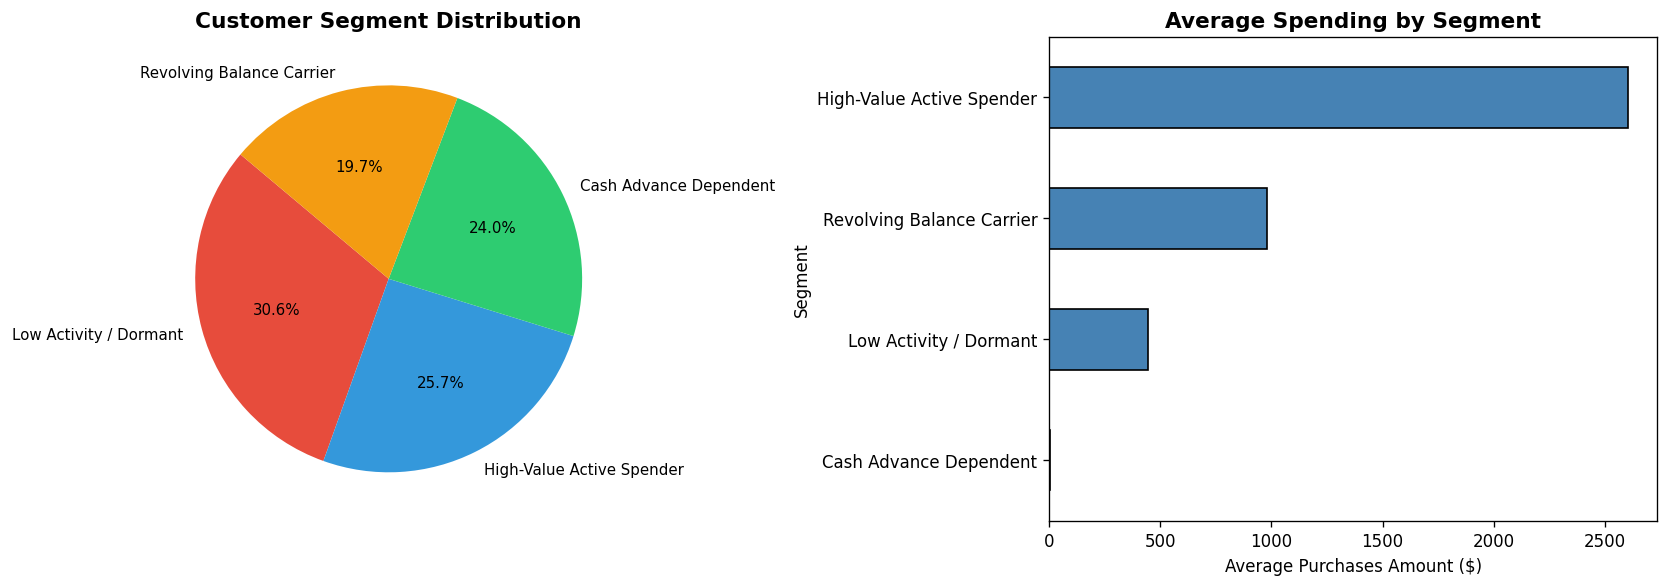

In [25]:
# Final summary: segment sizes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart of segment sizes
ax = axes[0]
sizes = df['Segment'].value_counts()
ax.pie(sizes, labels=sizes.index, autopct='%1.1f%%', colors=colors[:len(sizes)],
       startangle=140, textprops={'fontsize': 9})
ax.set_title("Customer Segment Distribution", fontsize=13, fontweight='bold')

# Bar chart of average spend per segment
ax = axes[1]
seg_spend = df.groupby('Segment')['purchases_amount'].mean().sort_values(ascending=True)
seg_spend.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel("Average Purchases Amount ($)")
ax.set_title("Average Spending by Segment", fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig("../reports/figures/segment_summary.png", dpi=150, bbox_inches='tight')
plt.show()

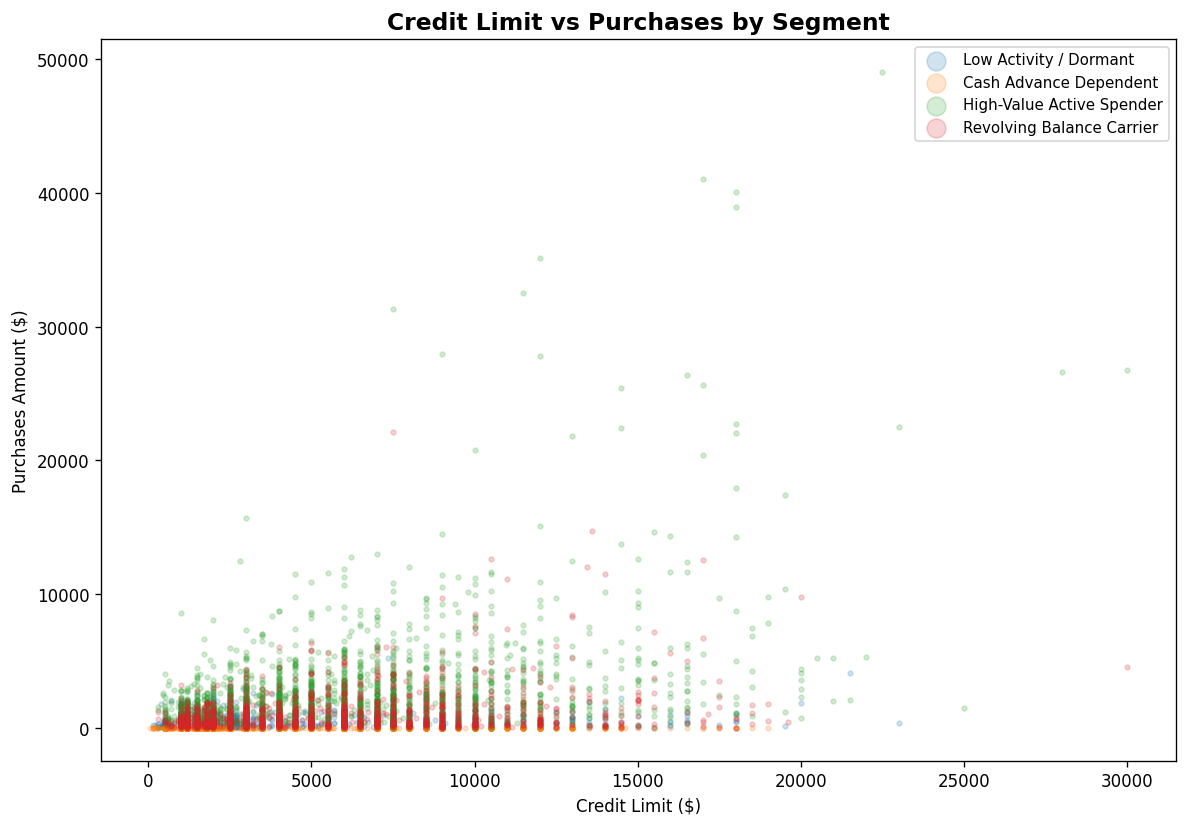

In [26]:
# Credit limit vs purchases colored by segment
fig, ax = plt.subplots(figsize=(10, 7))
for seg in df['Segment'].unique():
    mask = df['Segment'] == seg
    ax.scatter(df.loc[mask, 'credit_limit'], df.loc[mask, 'purchases_amount'],
               alpha=0.2, s=8, label=seg)
ax.set_xlabel("Credit Limit ($)")
ax.set_ylabel("Purchases Amount ($)")
ax.set_title("Credit Limit vs Purchases by Segment", fontsize=14, fontweight='bold')
ax.legend(markerscale=4, fontsize=9)
plt.tight_layout()
plt.savefig("../reports/figures/segment_credit_vs_purchases.png", dpi=150, bbox_inches='tight')
plt.show()

---
## 10. Challenges & Limitations

1. **Skewed distributions:** Most monetary features are heavily right-skewed. Log transformation helps but doesn't fully normalize all features. Robust alternatives like Yeo-Johnson transforms could be explored.

2. **Choosing k:** There is no single "correct" number of clusters. We used a combination of the elbow method, silhouette scores, and business interpretability. Different values of k yield different — but potentially equally valid — segmentations.

3. **K-Means assumptions:** K-Means assumes spherical, equally-sized clusters, which may not hold for this data. Density-based methods (DBSCAN, HDBSCAN) or Gaussian Mixture Models could capture more complex cluster shapes.

4. **Feature engineering choices:** The engineered features (ratios) were chosen based on domain intuition. Alternative features (e.g., trend over time, if available) could yield different segments.

5. **Stability:** Segments should be validated with out-of-time data. The current analysis is cross-sectional (6 months snapshot), so temporal dynamics are not captured.

6. **Missing values:** 298 missing `min_payments` values were imputed with the median. This is a simple approach; multiple imputation or model-based methods could be more sophisticated.

---
## 11. Conclusion

This analysis segmented ~8,500 credit card customers into distinct behavioral groups using K-Means clustering. The key finding is that customers naturally separate along two main dimensions: **spending behavior** (purchases vs cash advances) and **payment discipline** (full payers vs balance revolvers).

Each segment has distinct characteristics that call for differentiated marketing strategies — from re-engagement campaigns for dormant accounts to VIP retention programs for premium spenders. The segmentation provides an actionable framework for the marketing team to prioritize resources and personalize communications.